In [1]:
import random
from math import floor 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [3]:
def curr_pl(loadout):
    return floor(sum(loadout.values())/len(loadout))

In [4]:
def init_simulation(starting_pl):
    return {slot: starting_pl for slot in "kinetic energy power head arms chest legs class".split()}

In [231]:
def new_drop(loadout, low, high, soft_cap = 1500, n_keys = 84, key_weights = (.5, .5), use_keys = True):
    slots = []
    pls = []
    pl = curr_pl(loadout)
    key_used = False
    
    pl_low = (pl+low) if (pl+low) < soft_cap else soft_cap
    pl_high = (pl+high) if (pl+high) < soft_cap else soft_cap
    
    if use_keys:
        h_or_k = random.choices(('Haul', 'Key'), weights=key_weights, k=1)[0]
    else:
        h_or_k = 'Haul'

    if n_keys and h_or_k == 'Key':
        if pl_low != pl_high:
            pls = (np.random.randint(pl_low, pl_high),)
        else:
            pls = [soft_cap,]
        slots = (random.choice(('kinetic', 'energy', 'power')),)
        n_keys -= 1
        key_used = True
    
    else:
        n_drops_for_haul = random.choices((1,2), weights = (0.8,0.2))[0]
        if pl_low != pl_high:
            pls = np.random.randint(pl_low, pl_high, size=n_drops_for_haul)
        else:
            pls = [soft_cap] * n_drops_for_haul
        slots = random.choices(tuple(loadout.keys()), k = n_drops_for_haul)
        if n_keys < 84:
            n_keys += 1
            key_used = False
    
    return slots, pls, n_keys, key_used

In [371]:
def power_level(loadout, low, high, soft_cap, total_keys, key_weights, starting_hauls, use_keys = True):
    n_drops = 0
    n_keys = total_keys
    n_keys_used = 0
    current_power_level = curr_pl(loadout)
    
    n_hauls = starting_hauls if starting_hauls else int(1e7)
    
    while (current_power_level < soft_cap) and n_hauls:
        pot_slots, pot_drops, n_keys, key_used = new_drop(loadout, low, high, soft_cap, n_keys, key_weights, use_keys = use_keys)
        
        if key_used:
            n_keys_used += 1
        else:
            n_hauls -= 1
        
        for i, pot_slot in enumerate(pot_slots):
            # Drops that exceed soft cap are wasted
            if loadout[pot_slot] <= soft_cap:
                loadout[pot_slot] = pot_drops[i]
        
        n_drops += 1
        current_power_level = curr_pl(loadout)
    return n_drops, n_keys_used

In [372]:
def simulate_power_level(starting_pl, soft_cap, low, high, starting_keys, key_weights, starting_hauls=None, epochs = int(1e3), use_keys = True):
    n_drop_sims = []
    n_keys_used = []
    for i in tqdm(range(epochs), bar_format = "{l_bar}{bar}{rate_fmt}"):
        loadout = init_simulation(starting_pl)
        n_drops, keys = power_level(loadout, low_drop, high_drop, soft_cap, starting_keys, key_weights, starting_hauls, use_keys)
        n_drop_sims.append(n_drops)
        n_keys_used.append(keys)
    return n_drop_sims, n_keys_used

---
# Basic simulation

In [390]:
starting_pl = 1350
soft_cap = 1500
low_drop = 6
high_drop = 9
starting_keys = 84
key_weights = (.7,.3)
epochs = 1e4

In [391]:
drops, keys_used = simulate_power_level(
    starting_pl,
    soft_cap,
    low_drop,
    high_drop,
    starting_keys,
    key_weights,
    epochs = int(epochs),
    use_keys = True
)
drop_data = pd.DataFrame(drops)
key_data = pd.DataFrame(keys_used)

  0%|          ?it/s

<Figure size 2400x1440 with 0 Axes>

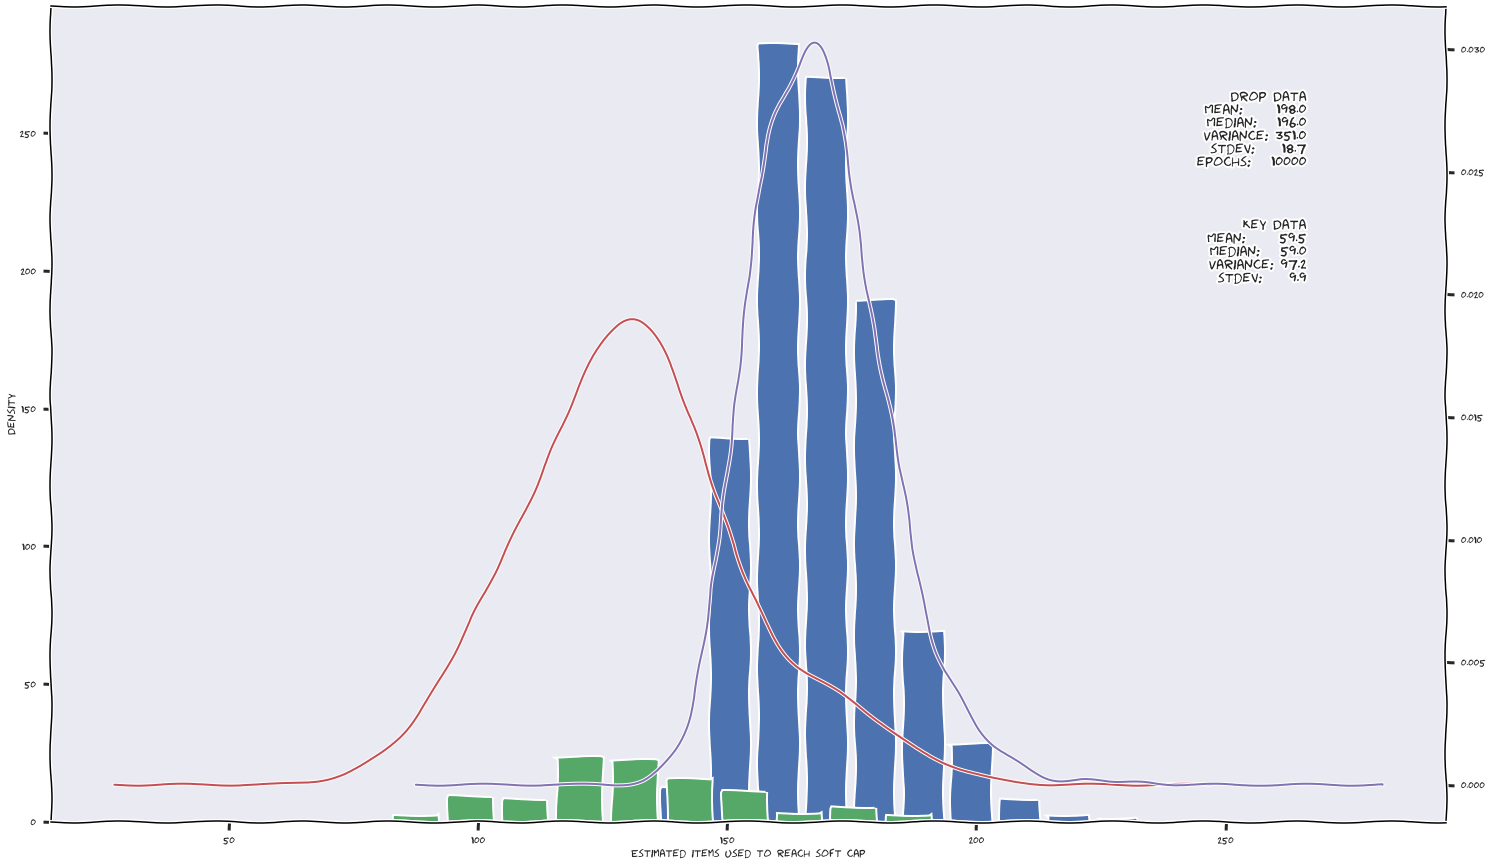

In [445]:
data = f"""Drop Data
Mean:     {round(drop_data.mean().values[0], 1)}
Median:   {round(drop_data.median().values[0], 1)}
Variance: {round(drop_data.var().values[0], 1)}
stdev:    {round(drop_data.std().values[0], 1)}
epochs:   {int(epochs)}"""

data_keys = f"""Key Data
Mean:     {round(key_data.mean().values[0], 1)}
Median:   {round(key_data.median().values[0], 1)}
Variance: {round(key_data.var().values[0], 1)}
stdev:    {round(key_data.std().values[0], 1)}"""

with plt.xkcd():
    plt.figure(figsize=(25,15), dpi=96)
    # plt.style.use('seaborn')
    plt.gcf().set_facecolor('white')
    ax = df.plot(kind='hist', legend=None, rwidth=.8, figsize=(25,15))
    df_keys.plot(kind='hist', ax = ax, legend=None, rwidth=.8, figsize=(25,15))
    df_keys.plot(kind='kde', ax = ax, secondary_y = True, legend=None)
    ax.text(
        .9,
        .85,
        data,
        horizontalalignment='center',
        verticalalignment='center',
        transform = ax.transAxes,
        ha = 'right'
    )
    
    ax.text(
        .9,
        .7,
        data_keys,
        horizontalalignment='center',
        verticalalignment='center',
        transform = ax.transAxes,
        ha = 'right'
    )
    ax.set_xlabel("Estimated items used to reach soft cap")
    df.plot(kind='kde', ax = ax, secondary_y = True, legend=None)
    plt.savefig('./drops_7v3')
    plt.show()

---
# Do number of keys matter?

In [398]:
haul_weights = np.linspace(0,1,num=10)
key_weights = 1-first

In [399]:
results = {
    'drops_collected': [],
    'keys_used' : []
}

for haul, key in zip(first, second):
    drops, keys_used = simulate_power_level(
        starting_pl,
        soft_cap,
        low_drop,
        high_drop,
        starting_keys,
        (haul, key),
        epochs = int(epochs),
        use_keys = True)
    d_dat = pd.DataFrame(drops)
    k_dat = pd.DataFrame(keys_used)
    results['drops_collected'].append(d_dat.mean()[0])
    results['keys_used'].append(k_dat.mean()[0])

  0%|          ?it/s

  0%|          ?it/s

  0%|          ?it/s

  0%|          ?it/s

  0%|          ?it/s

  0%|          ?it/s

  0%|          ?it/s

  0%|          ?it/s

  0%|          ?it/s

  0%|          ?it/s

In [400]:
drops_with_keys = pd.DataFrame(results['drops_collected'], index=first)
keys_with_drops = pd.DataFrame(results['keys_used'], index=second)

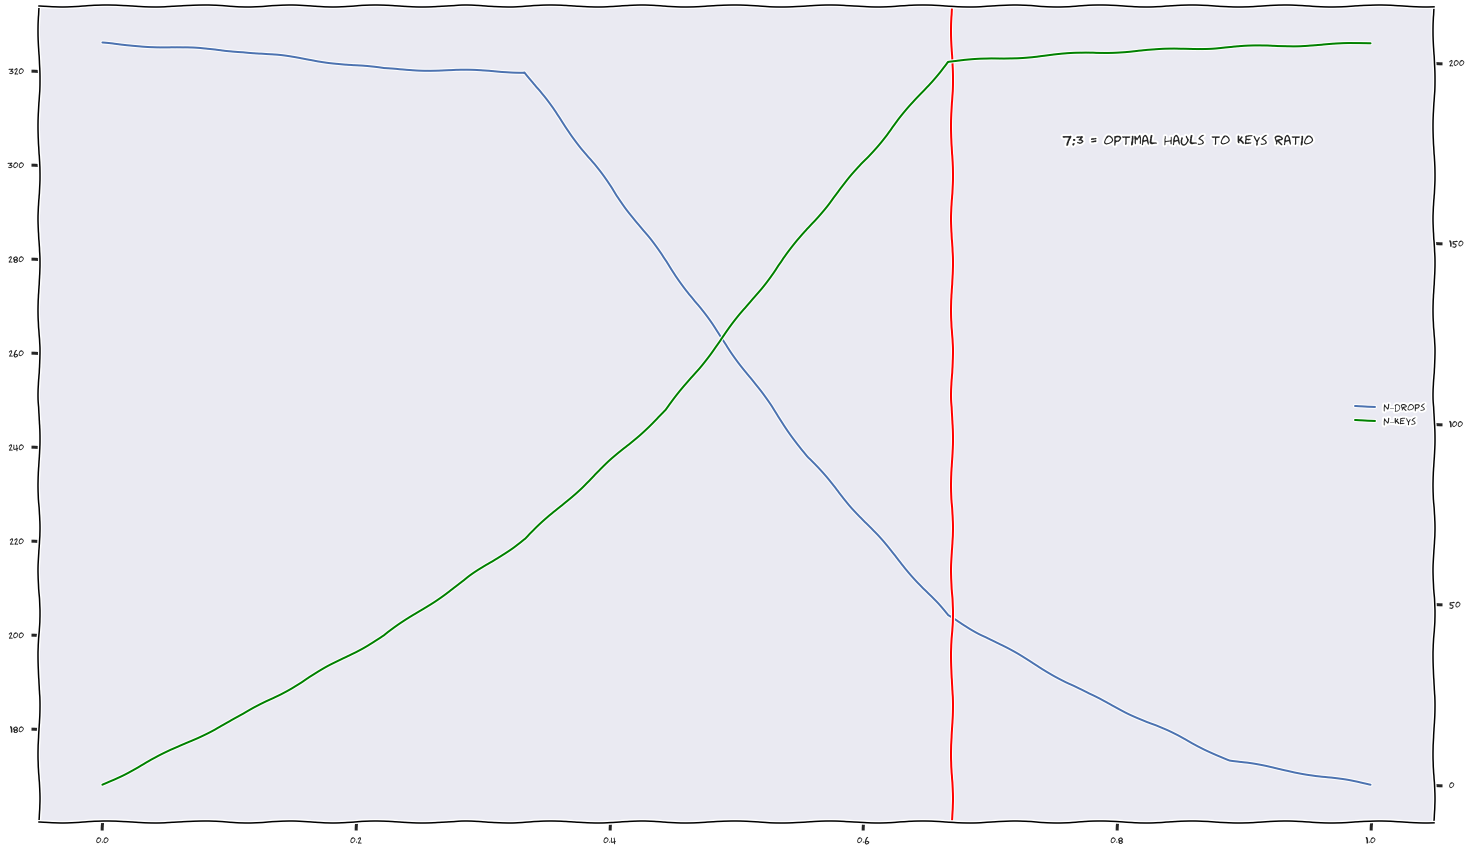

In [481]:
with plt.xkcd():
    fig, ax1 = plt.subplots()
    fig.set_size_inches(25,15)
    plt.gcf().set_facecolor('white')
    ax2 = ax1.twinx()
    d, = ax1.plot(drop_by_keys, label = 'n_drops')
    k, = ax2.plot(keys_with_drops, 'g-', label = 'n_keys')
    blended = [d,k]
    ax1.legend(blended, [p.get_label() for p in blended], loc = 'center right')
    ax1.axvline(.67, color = 'red')
    ax1.text(
        .6,
        .7,
        """7:3 = optimal hauls to keys ratio""",
        horizontalalignment='left',
        verticalalignment='bottom',
        transform = ax.transAxes,
    )
    plt.savefig('./keys_vs_hauls')

---
# Starting Hauls

In [231]:
def new_drop_hauls(loadout, low, high, soft_cap = 1500, n_keys = 84, key_weights = (.5, .5), use_keys = True):
    slots = []
    pls = []
    pl = curr_pl(loadout)
    key_used = False
    
    pl_low = (pl+low) if (pl+low) < soft_cap else soft_cap
    pl_high = (pl+high) if (pl+high) < soft_cap else soft_cap
    
    if use_keys:
        h_or_k = random.choices(('Haul', 'Key'), weights=key_weights, k=1)[0]
    else:
        h_or_k = 'Haul'

    if n_keys and h_or_k == 'Key':
        if pl_low != pl_high:
            pls = (np.random.randint(pl_low, pl_high),)
        else:
            pls = [soft_cap,]
        slots = (random.choice(('kinetic', 'energy', 'power')),)
        n_keys -= 1
        key_used = True
    
    else:
        n_drops_for_haul = random.choices((1,2), weights = (0.8,0.2))[0]
        if pl_low != pl_high:
            pls = np.random.randint(pl_low, pl_high, size=n_drops_for_haul)
        else:
            pls = [soft_cap] * n_drops_for_haul
        slots = random.choices(tuple(loadout.keys()), k = n_drops_for_haul)
        if n_keys < 84:
            n_keys += 1
            key_used = False
    
    return slots, pls, n_keys, key_used

In [509]:
def power_level_hauls(loadout, low, high, soft_cap, total_keys, key_weights, starting_hauls, use_keys = True):
    n_drops = 0
    n_keys = total_keys
    n_keys_used = 0
    current_power_level = curr_pl(loadout)
    
    n_hauls = starting_hauls if starting_hauls else int(1e7)
    
    while current_power_level < soft_cap:
        pot_slots, pot_drops, _, key_used = new_drop(loadout, low, high, soft_cap, n_keys, key_weights, use_keys = use_keys)
        
        if not key_used:
            n_hauls -= 1
        
        for i, pot_slot in enumerate(pot_slots):
            # Drops that exceed soft cap are wasted
            if loadout[pot_slot] <= soft_cap:
                loadout[pot_slot] = pot_drops[i]
        
        
        n_drops += 1
        current_power_level = curr_pl(loadout)
        
        if n_hauls < 1:
            break
    return current_power_level

In [510]:
def simulate_power_level_hauls(starting_pl, soft_cap, low, high, starting_keys, key_weights, starting_hauls=None, epochs = int(1e3), use_keys = True):
    max_pls = []
    for i in range(epochs):
        loadout = init_simulation(starting_pl)
        power_level = power_level_hauls(loadout, low_drop, high_drop, soft_cap, starting_keys, key_weights, starting_hauls, use_keys)
        max_pls.append(power_level)
    return max_pls

In [511]:
starting_pl = 1350
soft_cap = 1500
low_drop = 6
high_drop = 9
starting_keys = 84
key_weights = (.7,.3)
epochs = 1e4

In [514]:
max_pl_hauls = {}
for starting_hauls in tqdm(range(1, 201, 5), bar_format = "{l_bar}{bar}{rate_fmt}"):
    max_pls = simulate_power_level_hauls(
        starting_pl,
        soft_cap,
        low_drop,
        high_drop,
        starting_keys,
        key_weights,
        starting_hauls,
        epochs = int(epochs),
        use_keys = True)

    pl_dat = pd.DataFrame(max_pls)
    max_pl_hauls[starting_hauls] = pl_dat.mean()[0]

  0%|          ?it/s

In [536]:
hauls_arr = np.asarray(list(max_pl_hauls.values()))

max_pl_hauls[list(max_pl_hauls.keys())[np.abs(hauls_arr - 1490).argmin()]]

1490.2589

In [533]:
pd.DataFrame.from_dict(max_pl_hauls, orient='index')

,0
1,1350.7891
6,1357.0230
11,1362.9982
16,1368.8873
21,1374.8941
26,1380.8809
31,1386.7238
36,1392.4557
41,1398.4357
46,1404.3899


<Figure size 576x396 with 0 Axes>

<Figure size 2400x1440 with 0 Axes>

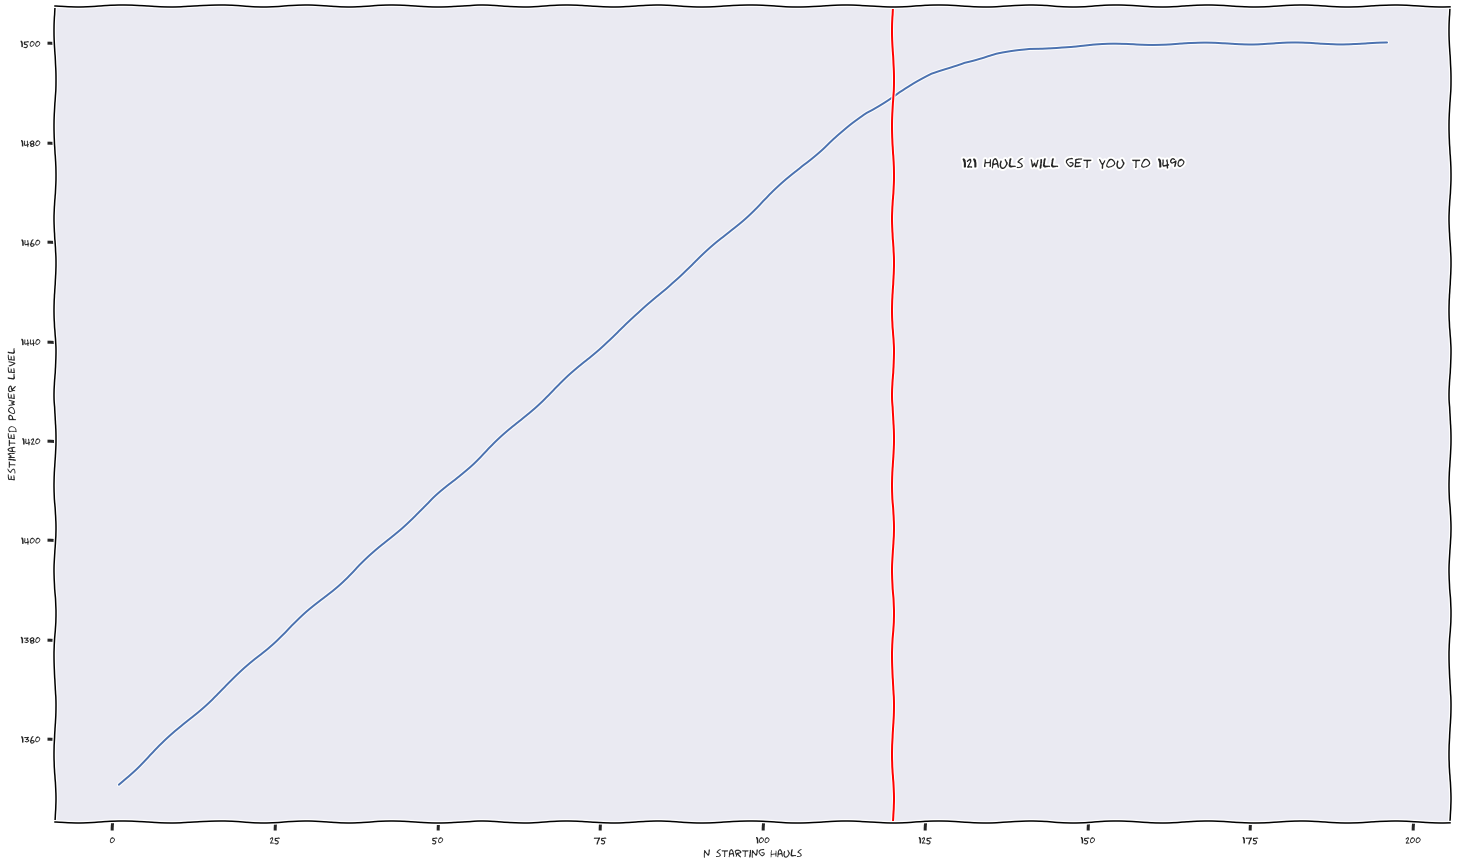

In [543]:
hauls_arr = np.asarray(list(max_pl_hauls.values()))
idx = list(max_pl_hauls.keys())[np.abs(hauls_arr - 1490).argmin()]

with plt.xkcd():
    plt.gcf().set_facecolor('white')
    plt.figure(figsize=(25,15), dpi=96)
    ax = pd.DataFrame.from_dict(max_pl_hauls, orient='index').plot.line(legend = False, figsize=(25,15))
    ax.axvline(120, color = 'red')
    plt.xlabel('n starting hauls')
    plt.ylabel('estimated power level')
    ax.text(
        .65,
        .8,
        f"""{idx} Hauls will get you to {floor(max_pl_hauls[idx])}""",
        horizontalalignment='left',
        verticalalignment='bottom',
        transform = ax.transAxes,
        ha = 'left'
    )
    plt.savefig('./starting_hauls')